# Develop ws estimator

This is likely a temporary example while working out the wins speed estimator method

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from floris import FlorisModel, TimeSeries

from flasc.utilities.floris_tools import estimate_ws_with_floris

## Load FlorisModel

In [2]:
file_path = Path.cwd()
fm_path = file_path / "../floris_input_artificial/gch.yaml"
fm = FlorisModel(fm_path)

# Set to 1 turbine layout
fm.set(layout_x=[0], layout_y=[0])

In [3]:
# Set to
N = 25
wind_speeds = np.linspace(0.01, 20.0, N)
time_series = TimeSeries(
    wind_speeds=wind_speeds, wind_directions=270.0, turbulence_intensities=0.06
)

fm.set(wind_data=time_series)

fm.run()

In [4]:
# Make a df_scada from the data
df_scada = pd.DataFrame(
    {
        "time": np.arange(0, N),
        "pow_000": fm.get_turbine_powers().squeeze() / 1000.0,
        "ws_000": wind_speeds + 1.0,  # Add 1m/s bias
    }
)
df_scada

,time,pow_000,ws_000
0,0,0.000000,1.010000
1,1,0.000000,1.842917
2,2,0.000000,2.675833
3,3,0.000000,3.508750
4,4,85.871284,4.341667
5,5,214.061051,5.174583
6,6,401.871370,6.007500
7,7,677.927512,6.840417
8,8,1030.443191,7.673333
9,9,1450.108488,8.506250


In [5]:
df_scada = estimate_ws_with_floris(df_scada, fm)
df_scada

,time,pow_000,ws_000,ws_est_000,ws_est_gain_000
0,0,0.000000,1.010000,1.370988,0.190999
1,1,0.000000,1.842917,2.211321,0.348510
2,2,0.000000,2.675833,2.789266,0.506021
3,3,0.000000,3.508750,3.104825,0.663532
4,4,85.871284,4.341667,3.511599,0.821043
5,5,214.061051,5.174583,4.182593,0.978554
6,6,401.871370,6.007500,4.991029,1.000000
7,7,677.927512,6.840417,5.821206,1.000000
8,8,1030.443191,7.673333,6.651383,1.000000
9,9,1450.108488,8.506250,7.481560,1.000000


## Calculate power with wind speed and estimated wind speed

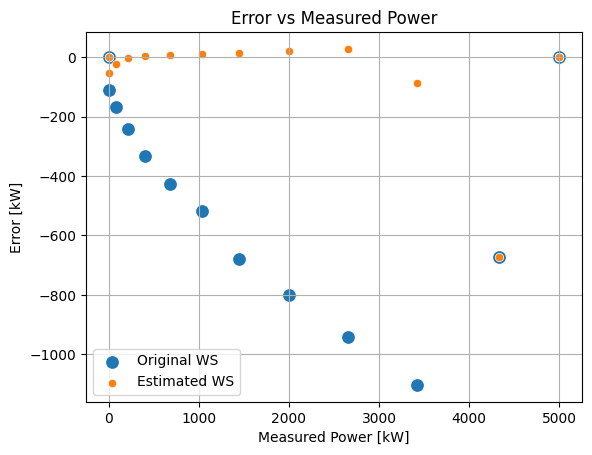

In [6]:
# Calculate with biased measurement
time_series = TimeSeries(
    wind_speeds=df_scada.ws_000.values, wind_directions=270.0, turbulence_intensities=0.06
)
fm.set(wind_data=time_series)
fm.run()
power_from_original_ws = fm.get_turbine_powers().squeeze() / 1000.0

# Calculate with estimated wind speed
time_series = TimeSeries(
    wind_speeds=df_scada.ws_est_000.values, wind_directions=270.0, turbulence_intensities=0.06
)
fm.set(wind_data=time_series)
fm.run()
power_from_estimated_ws = fm.get_turbine_powers().squeeze() / 1000.0

# Compute the error of each relative to measured power
original_ws_error = df_scada.pow_000.values - power_from_original_ws
estimated_ws_error = df_scada.pow_000.values - power_from_estimated_ws

# Plot the error against the measured power
fig, ax = plt.subplots()
sns.scatterplot(x=df_scada.pow_000, y=original_ws_error, ax=ax, label="Original WS", s=100)
sns.scatterplot(x=df_scada.pow_000, y=estimated_ws_error, ax=ax, label="Estimated WS")
ax.set_xlabel("Measured Power [kW]")
ax.set_ylabel("Error [kW]")
ax.set_title("Error vs Measured Power")
ax.grid(True)
plt.show()

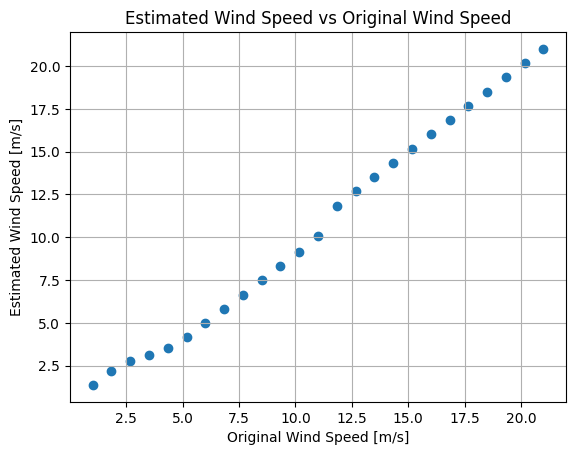

In [7]:
fig, ax = plt.subplots()
ax.scatter(df_scada["ws_000"], df_scada["ws_est_000"])
ax.set_xlabel("Original Wind Speed [m/s]")
ax.set_ylabel("Estimated Wind Speed [m/s]")
ax.set_title("Estimated Wind Speed vs Original Wind Speed")
ax.grid(True)
plt.show()